# EDA Lab + Homework (Student)

**Goal**: practice high-signal EDA like you would in a FAANG ML interview or on-call investigation.

Rules:
- Work top-to-bottom
- Don't hardcode outputs
- Prefer concise, high-signal plots


In [32]:
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def check(name: str, cond: bool):
    if not cond:
        raise AssertionError(f"Failed: {name}")
    print(f"OK: {name}")

rng = np.random.default_rng(0)

# Offline dataset (embedded CSV). Synthetic but realistic pitfalls: missingness, heavy tails, leakage-like columns.
CSV = """user_id,country,plan,signup_days_ago,tenure_days,sessions_last_7d,avg_session_min,age,discount_pct,last_payment_failed,churned,refund_after_churn_flag
1,US,basic,400,365,2,8.0,25,0.0,0,0,0
2,US,premium,120,110,18,22.0,41,10.0,0,0,0
3,IN,basic,30,25,1,3.0,19,0.0,1,1,1
4,IN,basic,10,7,0,2.0,22,0.0,1,0,0
5,GB,premium,800,790,30,35.0,52,15.0,0,0,0
6,GB,basic,200,180,5,10.0,33,,1,1,1
7,US,basic,60,55,7,12.0,,0.0,0,0,0
8,CA,premium,90,80,14,18.0,29,5.0,0,0,0
9,CA,basic,15,12,0,1.0,24,0.0,1,1,1
10,IN,premium,300,280,20,25.0,38,20.0,0,0,0
11,US,premium,5,3,0,0.5,27,0.0,1,1,1
12,GB,premium,45,40,9,15.0,31,0.0,0,0,0
13,US,basic,500,490,1,6.0,47,0.0,0,0,0
14,IN,basic,75,70,4,9.0,28,0.0,0,0,0
15,CA,basic,365,360,3,7.0,36,0.0,0,0,0
16,US,premium,20,18,0,1.0,23,0.0,1,1,1
17,GB,basic,150,140,6,11.0,42,0.0,0,0,0
18,IN,premium,220,210,25,28.0,34,25.0,0,0,0
19,US,basic,12,10,0,0.2,21,0.0,1,1,1
20,CA,premium,600,590,22,26.0,55,0.0,0,0,0
"""

df = pd.read_csv(io.StringIO(CSV))
check('n_rows', df.shape[0] == 20)
check('has_target', 'churned' in df.columns)
df.head()


OK: n_rows
OK: has_target


,user_id,country,plan,signup_days_ago,tenure_days,sessions_last_7d,avg_session_min,age,discount_pct,last_payment_failed,churned,refund_after_churn_flag
0,1,US,basic,400,365,2,8.0,25.0,0.0,0,0,0
1,2,US,premium,120,110,18,22.0,41.0,10.0,0,0,0
2,3,IN,basic,30,25,1,3.0,19.0,0.0,1,1,1
3,4,IN,basic,10,7,0,2.0,22.0,0.0,1,0,0
4,5,GB,premium,800,790,30,35.0,52.0,15.0,0,0,0


## 1) Sanity Checks — 10 minutes


### Task 1.1: Data grain + schema


In [33]:
# TODO: write 1-2 sentences: what is the grain of this dataset?
# One row per user (user_id), representing a single snapshot of that user’s current or most recent state.

# TODO: inspect dtypes; convert to appropriate types if needed
df.dtypes

# HINT: churned should be int/bool; categorical columns should remain object/category


user_id                      int64
country                     object
plan                        object
signup_days_ago              int64
tenure_days                  int64
sessions_last_7d             int64
avg_session_min            float64
age                        float64
discount_pct               float64
last_payment_failed          int64
churned                      int64
refund_after_churn_flag      int64
dtype: object

### Task 1.2: Missingness + duplicates


In [34]:
# TODO: build a missingness table with columns [n_missing, pct_missing] sorted desc
def missingness_table(df: pd.DataFrame) -> pd.DataFrame:
    # raise NotImplementedError
    n = len(df)
    n_missing = df.isna().sum()
    
    pct = (n_missing/n).sort_values(ascending=False)
    out = pd.DataFrame({"n_missing" : n_missing, "pct_missing" : (n_missing / n)})

    return out.sort_values("pct_missing", ascending=False)


miss = missingness_table(df)
miss
check('miss_has_cols', set(miss.columns) >= {'n_missing','pct_missing'})

# TODO: check duplicate rows and duplicate user_id
n_dup_rows = int(df.duplicated().sum())
n_dup_user_id = int(df['user_id'].duplicated().sum())
print(n_dup_rows, n_dup_user_id)


OK: miss_has_cols
0 0


## 2) Distributions + Outliers — 15 minutes


### Task 2.1: Numeric summaries


In [35]:
# TODO: compute summary stats (mean/median/std/quantiles) for numeric columns
# HINT: Select only Numeric Columns
num = df.select_dtypes(include = [np.number])
# print(num)
summary = num.describe(percentiles=[0.05, 0.50, 0.75, 0.95]).T
summary


,count,mean,std,min,5%,50%,75%,95%,max
user_id,20.0,10.500000,5.916080,1.0,1.950,10.5,15.25,19.05,20.0
signup_days_ago,20.0,200.850000,226.280514,5.0,9.750,105.0,316.25,610.00,800.0
tenure_days,20.0,191.750000,222.845208,3.0,6.800,95.0,300.00,600.00,790.0
sessions_last_7d,20.0,8.350000,9.615092,0.0,0.000,4.5,15.00,25.25,30.0
avg_session_min,20.0,11.985000,10.464188,0.2,0.485,9.5,19.00,28.35,35.0
age,19.0,33.000000,10.561986,19.0,20.800,31.0,39.50,52.30,55.0
discount_pct,19.0,3.947368,7.742191,0.0,0.000,0.0,2.50,20.50,25.0
last_payment_failed,20.0,0.350000,0.489360,0.0,0.000,0.0,1.00,1.00,1.0
churned,20.0,0.300000,0.470162,0.0,0.000,0.0,1.00,1.00,1.0
refund_after_churn_flag,20.0,0.300000,0.470162,0.0,0.000,0.0,1.00,1.00,1.0


### Task 2.2: Plot 2 high-signal distributions


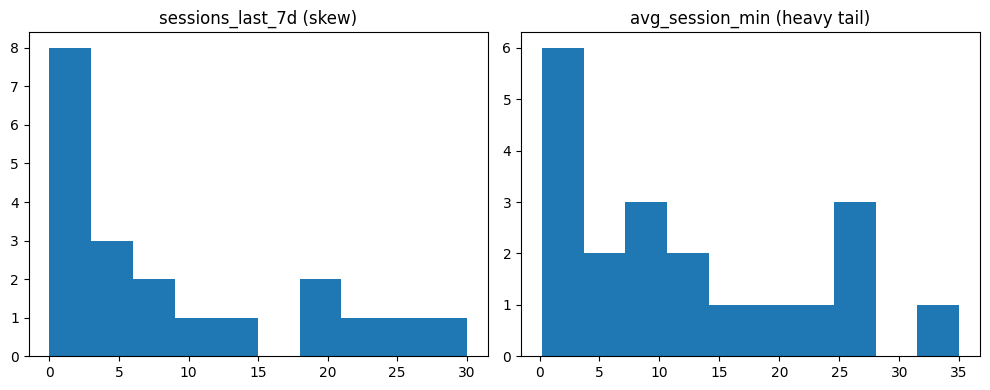

In [36]:
# TODO: pick 2 columns and create 2 plots that reveal something non-trivial
# Example: sessions_last_7d (skew), avg_session_min (heavy tail), tenure_days (range)
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
# TODO
plt.hist(df['sessions_last_7d'], bins = 10)
plt.title('sessions_last_7d (skew)')
plt.subplot(1,2,2)
# TODO...
plt.hist(df['avg_session_min'], bins = 10)
plt.title('avg_session_min (heavy tail)')
plt.tight_layout()
plt.show()


## 3) Target + Slices — 15 minutes


### Task 3.1: Label imbalance


In [37]:
# TODO: compute churn rate and counts
churn_rate = float(df['churned'].mean())
counts = df['churned'].value_counts().rename_axis('churned').to_frame('n')
print(churn_rate)
counts

# Checkpoint: which metric would you choose (accuracy vs F1 vs PR-AUC) and why?


0.3


,n
churned,
0,14
1,6


### Task 3.2: Slice analysis


In [38]:
# TODO: compute churn rate by country and by plan
by_country = df.groupby('country')['churned'].mean().sort_values(ascending=False)
by_plan = df.groupby('plan')['churned'].mean().sort_values(ascending=False)
# print(by_country)
# print(by_plan)

# TODO: create a tenure bucket column and compute churn by bucket
# HINT: pd.cut
df2 = df.copy()
df2["tenure_bucket"] = pd.cut(df2['tenure_days'], bins=[-1, 14, 60, 180, 10_000], labels = ['<=2w', '2w-2m', '2m-6m', '>6m'])
# print(df2)
by_bucket = df2.groupby('tenure_bucket')['churned'].mean().sort_values(ascending=False)
print(by_bucket)


tenure_bucket
<=2w     0.75
2w-2m    0.50
2m-6m    0.20
>6m      0.00
Name: churned, dtype: float64


C:\Users\Manasi\AppData\Local\Temp\ipykernel_27032\697994462.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  by_bucket = df2.groupby('tenure_bucket')['churned'].mean().sort_values(ascending=False)


## 4) Leakage + Time — 10 minutes


### Task 4.1: Identify leakage-prone features


In [39]:
# TODO: identify columns that likely leak label or post-outcome info.
# HINT: refund_after_churn_flag looks suspicious.
leaky_cols = ['refund_after_churn_flag']
leaky_cols

# TODO: write 2-3 sentences explaining why each is leaky (prediction-time availability).
# refund_after_churn_flag - refunds are processed post cancellations. At prediction time, this information does not exist.
# last_payment_failed - this flag reflects a payment attempt, it would not be known at prediction time.
# Therefore, a feature is leaky if it wouldn’t be available at the exact moment we make the prediction regardless of how predictive it looks offline.

['refund_after_churn_flag']

## 5) Homework — EDA Write-up


In 10–15 bullets:
- Top 5 data issues/risks
    1.) Data Leakage
    2.) Class imbalance is most likely minority. It affects metrics and model choice.
    3.) Missing values - null data
    4.) Time leakage risk - aggregations must be confirmed before churn.
    5.) Not enough data points to train models to get appropriate results.

- Top 3 features to create next
    1.) for Inactivity, if a user hasn't used the product recently, they're at high churn risk
        Therefore, is_inactive = (sessions_last_7d == 0)
    2.) Something like a Lifecycle Bucket, a users lifecycle stage that determines the churn possibility
        new (<= 30days>),
        early (31-90 days),
        intermediate (91-365 days),
        long-term (> 365)

- What you would do before training any model
    1.) Define prediction time explicitly - ensure every feature is available before the churn.
    2.) Remove leakgae columns - drop and validate leaky columns
    3.) Validate grain - enforcing no duplications.
    4.) Baseline sanity check 
    5.) Handle missing values
